In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/SpDev/SpCommon")
sys.path.append("/home/salmon/workspace/SpDev/SpDB")

import collections
from spdm.util.logger import logger
from spdm.data.Collection import Collection
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import math

In [2]:
db = Collection("east+mdsplus:///home/salmon/public_data/~t/",default_tree_name="efit_east")
entry = db.open(shot=55555).entry

2020-11-02 06:56:52,568 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:76:sp_find_module: Can not find module spdm.data.plugins.Plugineast#eastCollection
2020-11-02 06:56:52,574 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:76:sp_find_module: Can not find module spdm.data.plugins.PluginEast#EastCollection
2020-11-02 06:56:52,576 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:74:sp_find_module: spdm.data.plugins.PluginEAST#EASTCollection
2020-11-02 06:56:52,577 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:77:find_plugin: Load Plugin: EASTCollection
2020-11-02 06:56:52,614 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:74:sp_find_module: spdm.data.plugins.PluginMDSplus#MDSplusCollection
2020-11-02 06:56:52,615 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:77:find_plugin: Load Plugin: MDSplusCollection
2020-11-02 06:56:52,617 DEBUG [spdm] /h

In [3]:
vessel_inner_points= np.array([entry.wall.description_2d.vessel.annular.outline_inner.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_inner.z.__value__()]).transpose([1,0]) 

vessel_outer_points= np.array([entry.wall.description_2d.vessel.annular.outline_outer.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_outer.z.__value__()]).transpose([1,0])  

limiter_points =  np.array([entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
                                 entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__()]).transpose([1,0]) 
isoflux=[
    (1.93, 0.15,    2.24, 0.52    ),   # isoflux03
    (1.99,0    ,    2.40, 0        ),     # isoflux01
    (1.93,-0.15,    2.24, -0.52    ),   # isoflux09
    (1.72, 0.24,    1.35, 0.45    ),   # isoflux04
    (1.66,0    ,    1.35, 0        ),     # isoflux06
    (1.72,-0.24 ,   1.35, -0.45    ),    # isoflux08

    ]                                 

In [4]:
sys.path.append("/home/salmon/workspace/freegs/")
import freegs
from freegs.machine import Machine,Wall
import freegs.equilibrium as equilibrium
import freegs.jtor as jtor
import freegs.picard as picard
import freegs.boundary as boundary
from  freegs.coil import Coil

In [9]:
itime=40000
coils = []
for coil in entry.pf_active.coil:
    rect = coil.element[0].geometry.rectangle.__value__()
    coils.append((str(coil.name), Coil(
    rect.r+rect.width/2, rect.z+rect.height/2,
    current= coil.current.data.__value__()[itime] ,
    turns=int(coil.element[0].turns_with_sign),
    # control=True
    )))

wall = Wall(entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
            entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__())

Rdim=entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__()
Zdim=entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__()

lfcs_r=entry.equilibrium.time_slice[10].boundary.outline.r.__value__()[:,0]
lfcs_z=entry.equilibrium.time_slice[10].boundary.outline.z.__value__()[:,0]

EASTTokamak = Machine(coils, wall)



rmin=min(Rdim)
rmax=max(Rdim)
zmin=min(Zdim)
zmax=max(Zdim)

eq = equilibrium.Equilibrium(tokamak=EASTTokamak,
                                Rmin=rmin, Rmax=rmax,
                                Zmin=zmin, Zmax=zmax,
                                nx=129, ny=129,
                                boundary=boundary.freeBoundaryHagenow)




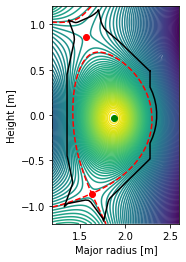

In [10]:
profiles = jtor.ConstrainPaxisIp(1e3,  # Plasma pressure on axis [Pascals]
                            1e6,  # Plasma current [Amps]
                            1.0)  # fvac = R*Bt

psivals = [ (R, Z, 0.0) for R, Z in zip(lfcs_r,lfcs_z)]
# psivals = [ (R, Z, 0.0) for R, Z in zip(entry.equilibrium.time_slice[10].boundary.outline.r.__value__(), 
#             entry.equilibrium.time_slice[10].boundary.outline.z.__value__()) ]


constrain = freegs.control.constrain(psivals=psivals)
freegs.solve(eq, profiles,constrain) 
ax=eq.plot(show=False)


<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

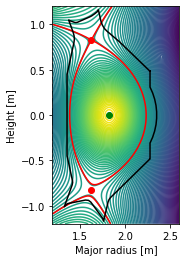

In [12]:
constrain=freegs.control.constrain(
    isoflux=[    
    ( 2.24, 0.52 ,  2.24,   -0.52     ),    
    ( 1.93, 0.15,   1.93,   -0.15,    ),    
    ( 1.99, 0 ,     1.66,   0),
  
   ],
    xpoints=[(1.63,-0.83),(1.63,0.83)]
)

freegs.solve(eq, profiles, constrain,maxits=200) 

eq.plot(show=False)




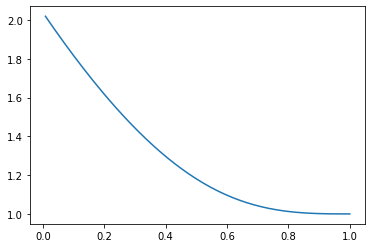

In [14]:
psinorm=np.linspace(1.0/128,1,128)
plt.plot(psinorm,eq.fpol(psinorm))

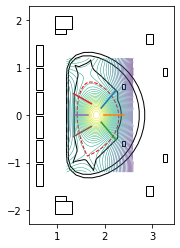

In [13]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points, fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True))

plt.gca().add_patch(plt.Polygon(np.array([lfcs_r,lfcs_z]).transpose([1,0]) , fill=False,closed=True,linestyle="dashed",color="red"))

for r0,z0,r1,z1 in isoflux:
    plt.plot([r0,r1],[z0,z1])

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0),float( rect.width), float(rect.height), fill=False))
 

# plt.contour(
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
#     linewidths=0.5,cmap="gray")

plt.contour(np.linspace(rmin,rmax,129),np.linspace(zmin,zmax,129),eq.psi().transpose(-1,0),levels=50,linewidths=0.5)


plt.axis('scaled')
plt.show()
